In [1]:
import sys
sys.path.insert(1, '..') # sets the import path to the parent folder

import time
import itertools
import numpy as np

import qiskit
from qiskit import *
from qiskit.quantum_info import Statevector
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B, SPSA
from qiskit.opflow.state_fns import StateFn, CircuitStateFn
from qiskit.providers.aer import StatevectorSimulator, AerSimulator

from qiskit.opflow import CircuitSampler

from qiskit.ignis.mitigation.measurement import CompleteMeasFitter # you will need to pip install qiskit-ignis
from qiskit.ignis.mitigation.measurement import complete_meas_cal

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import BoundaryNorm
cmap = plt.get_cmap("plasma") #'viridis'

from modules.utils import *

from qae import *

import datetime

In [2]:
from tenpy.networks.mps import MPS
from tenpy.models.hubbard import BoseHubbardChain
from tenpy.algorithms import dmrg
from tenpy.linalg import np_conserved

def DMRG_EBH(L, V, t_list, chi_max=30, bc_MPS='infinite'):

    model_params = dict(n_max=1, filling=0.5, bc_MPS=bc_MPS, t=t_list,
                        L=L, V=V, mu=0, conserve='N')
    M = BoseHubbardChain(model_params)
        
    vector=[]
    for i in range(M.lat.N_sites):
        if i%2:
            vector.append(1)
        else:
            vector.append(0)

    psi = MPS.from_product_state(M.lat.mps_sites(), vector, bc=M.lat.bc_MPS)    
        
    dmrg_params = {                                                                                             
        'mixer': True,                                                                                          
        'trunc_params': {                                                                                       
        'chi_max': chi_max,                                                                                                                                                                    
        },                                                                                                      
        'max_E_err': 1.e-16,                                                                                    
        #'verbose': 0
    }
    
    info = dmrg.run(psi, M, dmrg_params)
    
    return info['E'], psi

/home/kkottmann/TeNPy/tenpy/tools/optimization.py:308: UserWarning: Couldn't load compiled cython code. Code will run a bit slower.
  warnings.warn("Couldn't load compiled cython code. Code will run a bit slower.")


In [3]:
print(qiskit.__version__, np.__version__)

0.17.4 1.20.1


In [4]:
#IBMQ.load_account() # this then automatically loads your saved account
#provider = IBMQ.get_provider(hub='ibm-q-research')

In [5]:
#device = provider.backend.ibmq_rome # 6 bogota ; 4 rome

In [6]:
### Real device execution:
#backend = device 

### Simulation with noise profile from real device
#backend = qiskit.providers.aer.AerSimulator.from_backend(device)

### Simulation without noise
backend = qiskit.providers.aer.AerSimulator(method="matrix_product_state")
#backend = StatevectorSimulator()

In [7]:
### Preliminaries
L = 10
num_trash = 2
anti = 1 # 1 for ferromagnetic Ising model, -1 for antiferromagnet

filename = "data/QAEAnsatz_scaling_MPS"

In [8]:
V = 1
deltat=1
chi = 2**3
print("bond dimension : ", chi)

bond dimension :  8


In [9]:
t_list = np.ones(L-1)
for i in range(len(t_list)):
    t_list[i] -= deltat*(-1)**i
E0, psi0 = DMRG_EBH(L, V, t_list, chi_max=chi, bc_MPS='finite')

/home/kkottmann/TeNPy/tenpy/algorithms/dmrg.py:1916: UserWarning: H is zero in the given block, nothing to diagonalize.We just return the initial state again.
  warnings.warn("H is zero in the given block, nothing to diagonalize."


Match qiskits way of encoding matrix product states. I.e. a state is composed of  
state = (A_list, S_list)  
where A_list is a list consisting of tuples of matrices (so having (A[0], A[1]) instead of A[2, chi, chi])  
and S_list are the singular values (can only assume so, the [documentation is trash](https://qiskit.org/documentation/stubs/qiskit.providers.aer.library.set_matrix_product_state.html#qiskit.providers.aer.library.set_matrix_product_state)!)  
I came to this conclusion by looking what `save_matrix_product_state` is saving and guessing from the shape of it:

### dummy-save a matrix product state to check shapes and conventions

In [10]:
thetas = np.random.rand(num_trash*(L+1))
QAE_circ = QAEAnsatz(num_qubits = L, num_trash_qubits= num_trash, trash_qubits_idxs = list(range(num_trash)), measure_trash=False).assign_parameters(thetas)

In [11]:
QAE_circ.save_matrix_product_state(label="my_mps")

In [12]:
result = backend.run(QAE_circ).result()

In [13]:
#result.data(0)["my_mps"]

In [14]:
[(_[0].shape, _[1].shape) for _ in result.data(0)["my_mps"][0]]

[((1, 2), (1, 2)),
 ((2, 4), (2, 4)),
 ((4, 8), (4, 8)),
 ((8, 16), (8, 16)),
 ((16, 16), (16, 16)),
 ((16, 16), (16, 16)),
 ((16, 8), (16, 8)),
 ((8, 4), (8, 4)),
 ((4, 2), (4, 2)),
 ((2, 1), (2, 1))]

In [15]:
[_.shape for _ in result.data(0)["my_mps"][1]]

[(2,), (4,), (8,), (16,), (16,), (16,), (8,), (4,), (2,)]

### Construct state in qiskit form

In [16]:
# G is only the local tensor (not multiplied by any singular values) - see https://tenpy.readthedocs.io/en/latest/reference/tenpy.networks.mps.html
A_list = [psi0.get_B(i, form="G").to_ndarray().transpose([1,0,2]) for i in range(L)]
for i,A in enumerate(A_list):
    A_list[i] = (A[0], A[1])

In [17]:
[(_[0].shape, _[1].shape) for _ in A_list]

[((1, 1), (1, 1)),
 ((1, 2), (1, 2)),
 ((2, 2), (2, 2)),
 ((2, 4), (2, 4)),
 ((4, 4), (4, 4)),
 ((4, 4), (4, 4)),
 ((4, 2), (4, 2)),
 ((2, 2), (2, 2)),
 ((2, 1), (2, 1)),
 ((1, 1), (1, 1))]

In [18]:
S_list = [psi0.get_SR(i) for i in range(L-1)] # skip trivial last bond; hast to be of size L-1

In [19]:
state = (A_list, S_list)

In [20]:
initcirc = QuantumCircuit(QuantumRegister(L,"q")) #,ClassicalRegister(num_trash, 'c')

In [21]:
initcirc.set_matrix_product_state(state)
initcirc.draw()

░ 
q_0: ─░─
      ░ 
q_1: ─░─
      ░ 
q_2: ─░─
      ░ 
q_3: ─░─
      ░ 
q_4: ─░─
      ░ 
q_5: ─░─
      ░ 
q_6: ─░─
      ░ 
q_7: ─░─
      ░ 
q_8: ─░─
      ░ 
q_9: ─░─
      ░

### Test validity
#### Check expectation value

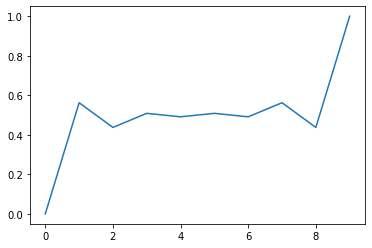

In [22]:
plt.plot(psi0.expectation_value("N"))

In [23]:
i=0

In [24]:
qi = qiskit.utils.QuantumInstance(backend=backend, # , seed_simulator=seed, seed_transpiler=seed
                                  shots = 1000,
                                  #coupling_map=coupling_map,
                                  #noise_model=noise_model, # comment out on real device execution
                                  #measurement_error_mitigation_cls= CompleteMeasFitter, 
                                  #cals_matrix_refresh_period=30  #How often to refresh the calibration matrix in measurement mitigation. in minutes
                                 )

In [25]:
QZ = np.zeros(L)

In [26]:
for i in range(L):
    meas_outcome = ~StateFn(QNKron(L,Z,I,i)) @ StateFn(initcirc)
    QZ[i] = CircuitSampler(qi).convert(meas_outcome).eval()

<ipython-input-26-50c7739f7155>:3: ComplexWarning: Casting complex values to real discards the imaginary part
  QZ[i] = CircuitSampler(qi).convert(meas_outcome).eval()


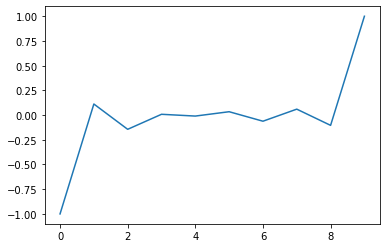

In [27]:
plt.plot(QZ)

shift in magnitude due to using $N$ type operator in tenpy and Pauli $Z$ in qiskit